# Evaluation

In [1]:
#!/bin/env python

import os

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import csv
import sys
import json
import math
from nltk.tokenize import word_tokenize

from tools.visual import *

pred_dir_path = 'data/pred'
save_dir = 'data/evaluation_results/'

# ./compare-psylle.py Cpruni_occurrences_binary.json extracted_entities.txt extracted_relations.txt >eval.json

sys.stdout.write('COMPARISON STARTED\n')
ref_filepath = 'data/ref/cpruni_occurrences_binary.json'
sys.stdout.write(ref_filepath) # label filepath

COMPARISON STARTED
data/ref/cpruni_occurrences_binary.json

## Load Subdirectories

In [2]:
#########################
## Load Subdirectories ##
#########################

# each subdirectory is an output of a variation of the same pipeline
# with different strategies implemented (for comparison)

In [3]:
def get_child_dir_paths(dir_path):
    child_names = os.listdir(dir_path)
    child_paths = [os.path.join(dir_path,child_name) for child_name in child_names]
    dir_paths = [child_path for child_path in child_paths if os.path.isdir(child_path)]
    return dir_paths


### Load predictions and reference data

In [4]:
## list filepaths of predictions
## both entities and relations

pred_filepaths = dict()

c = 0 # subdirectories are named sequentially starting from 0
for dirpath in get_child_dir_paths(pred_dir_path):
    pred_ent_filepaths = []
    pred_rel_filepaths = []
    for filepath in os.listdir(dirpath):
        filepath = os.path.join(pred_dir_path,str(c),filepath)
        
        if 'ent' in filepath:
            pred_ent_filepaths.append(filepath)
        elif 'rel' in filepath:
            pred_rel_filepaths.append(filepath)

        pred_filepaths_in_dir = list(zip(pred_ent_filepaths, pred_rel_filepaths))
        pred_filepaths[c] = pred_filepaths_in_dir
    c += 1

    # e.g. of pred_filepaths:
    # {0: [('data/pred/0/extracted_entities.txt', # pipeline version 0, entities
    #    'data/pred/0/extracted_relations.txt')], # pipeline version 0, relations
    #  1: [('data/pred/1/extracted_entities.txt', # pipeline version 1, entities
    #    'data/pred/1/extracted_relations.txt')]} # pipeline version 1, relations


## load content of reference data

#reference_nomeclature_db_filepath = '../../../text-mining-workflow/ancillaries/psylve/psyllist_tokens.txt'
#with open(reference_nomeclature_db_filepath, 'r') as f:
#    reference_nomeclature_db = f.read()



## Evaluation

### Def Functions

#### Scores

In [5]:

##########################
## Evaluation Functions ##
##########################

# Either reference and prediction document names are the same
def same_doc(ref, pred):
    return pred == ref or pred == ref + '_translation'

# Similarity between vectors
def sim_vector(ref, pred):
    #for token1 in word_tokenize(ref['acceptedNameUsage'].lower()):
        #for token2 in word_tokenize(pred['CANONICAL'].lower()):
            #if token1==token2:
            # FOR ALL HEMIPTERA: if token2 in reference_nomeclature_db.lower():
    if 'psyll' in pred['CANONICAL'].lower():
        return 1.0
    return 0.0

# Similarity between locations
def sim_location(ref, pred):
    for token1 in word_tokenize(ref['country'].lower()):
        for token2 in word_tokenize(pred['FORM'].lower()):
            if token1==token2:
                return 1.0
    return 0.0


# Similarity between hosts
def sim_host(ref, pred):
    for token1 in word_tokenize(ref['hostPlantLatinName'].lower()):
        for token2 in word_tokenize(pred['CANONICAL'].lower()):
            if token1==token2:
                return 1.0
    return 0.0

# Similarity between dates
def sim_date(ref, pred):
    if ref['eventDate'][-4:] == pred['FORM']:
        return 1.0
    return 0.0


TYPES = ('vector', 'location', 'host', 'date')

class hashabledict(dict):
    def __hash__(self):
        return hash(tuple(sorted(self.items())))

#### Pair entities

In [6]:
################
## Pairing up ##
################

sim_fun = {
    'vector': sim_vector,
    'location': sim_location,
    'host': sim_host,
    'date': sim_date
}


def sim(ref, pred):
    if ref['type'] != pred['TYPE']:
        return 0.0
    if not same_doc(ref['filename'], pred['DOC']):
        return 0.0
    return sim_fun[ref['type']](ref, pred)


def find_best_ent(paired_pred, ref_ent, pred_entities):
    max_sim = 0.0
    best_pred = None
    for pred_ent in pred_entities:
        if pred_ent in paired_pred:
            continue
        s = sim(ref_ent, pred_ent)
        if s == 0.0:
            continue
        if s > max_sim:
            max_sim = s
            best_pred = pred_ent
    return best_pred, max_sim


# return True if inputted parameters are the same
def pair_filter(pair, doc=None, type_=None, cat=None):
    r = pair['ref']
    p = pair['pred']
    if doc is not None:
        if r is not None and r['filename'] != doc:
            return False
        if p is not None and not same_doc(doc, p['DOC']):
            return False
    if type_ is not None:
        if r is not None and r['type'] != type_:
            return False
        if p is not None and p['TYPE'] != type_:
            return False
    if cat is not None:
        return cat == pair['cat']
    return True

In [43]:

def evaluate(ref_filepath, pred_ent_filepath, pred_rel_filepath, out='doc'):       
    with open(ref_filepath) as f:
        reference = json.load(f)
    ref_documents = set(ref['common']['filename'] for ref in reference)
    ref_entities = set()
    for ref in reference:
        fn = ref['common']['filename']
        ref_entities.add(hashabledict(ref['left']))
        ref_entities.add(hashabledict(ref['right']))

    with open(pred_ent_filepath, newline='') as f:
        entcsv = csv.DictReader(f, delimiter='\t')
        pred_entities = set(hashabledict(row) for row in entcsv)

    with open(pred_rel_filepath, newline='') as f:
        relcsv = csv.DictReader(f, delimiter='\t')
        pred_relations = set(hashabledict(row) for row in relcsv)

    TRUE_POSITIVE = 'True Positive'
    FALSE_POSITIVE = 'False Positive'
    FALSE_NEGATIVE = 'False Negative'

    pred_documents = set(pred_ent['DOC'].replace('_translation', '') for pred_ent in pred_entities)
    ref_entities = set(ref_ent for ref_ent in ref_entities if ref_ent['filename'] in pred_documents)

    ent_pairs = []
    paired_pred = set()

    for ref_ent in ref_entities:
        pred_ent, s = find_best_ent(paired_pred, ref_ent, pred_entities)
        if pred_ent is not None:
            paired_pred.add(pred_ent)
            #print('PAIRED P', paired_pred)
            cat = TRUE_POSITIVE
        else:
            cat = FALSE_NEGATIVE
        ent_pairs.append({'ref': ref_ent, 'pred': pred_ent, 'sim': s, 'cat': cat})
        #print('ENT PAIR', ent_pairs)
    for pred_ent in pred_entities:
        if pred_ent not in paired_pred:
            ent_pairs.append({'ref': None, 'pred': pred_ent, 'sim': 0.0, 'cat': FALSE_POSITIVE})

    def evaluate_pairs(pairs):
        tp = list(p for p in pairs if pair_filter(p, cat=TRUE_POSITIVE))
        fp = list(p for p in pairs if pair_filter(p, cat=FALSE_POSITIVE))
        fn = list(p for p in pairs if pair_filter(p, cat=FALSE_NEGATIVE))
        if len(tp) + len(fn) == 0:
            recall = math.nan
        else:
            recall = float(len(tp)) / (len(tp) + len(fn))
        if len(tp) + len(fp) == 0:
            precision = math.nan
        else:
            precision = float(len(tp)) / (len(tp) + len(fp))
        if recall + precision == 0:
            f1 = math.nan
        else:
            f1 = 2 * recall * precision / (recall + precision)
        return recall, precision, f1

    # per doc evaluation
    ent_eval = {}
    for doc in pred_documents:
        if str(doc) not in str(pred_entities):
            continue
        ent_doc_eval = {}
        for type_ in TYPES:
            pairs = list(p for p in ent_pairs if pair_filter(p, doc=doc, type_=type_))

            recall, precision, f1 = evaluate_pairs(pairs)
            ent_doc_eval[type_] = {
                'pairs': pairs,
                'recall': recall,
                'precision': precision,
                'f1': f1
            }
        ent_eval[doc] = ent_doc_eval

    ## per type evaluation
    ent_type_eval = {}     
    for type_ in TYPES:
        pairs = list(p for p in ent_pairs if pair_filter(p, type_=type_))
        recall, precision, f1= evaluate_pairs(pairs)
        try:
            ent_doc_eval[type_] = {
                'pairs': ent_type_eval[type_]['pairs']+[pairs],
                'recall': ent_type_eval[type_]['recall']+recall,
                'precision': ent_type_eval[type_]['precision']+precision,
                'f1': ent_type_eval[type_]['f1']+f1
            }
        except KeyError:
            ent_type_eval[type_] = {
            'pairs': [pairs],
            'recall': recall,
            'precision': precision,
            'f1': f1
        }
           

    if out=='doc':
        return ent_eval

    else:
        return ent_type_eval



### Calculate Scores

Calculate scores for each pipeline version

In [44]:
####################
## compute Scores ##
####################

sys.stdout.write('COMPUTING SCORES\n')

COMPUTING SCORES


In [45]:
#import nltk
#nltk.download('punkt')
    
ent_evals = {}
ent_type_evals = {}
c = 0
for dir,files in pred_filepaths.items():
    pred_ent_filepath = [path for path in files[0] if 'ent' in path][0]
    pred_rel_filepath = [path for path in files[0] if 'rel' in path][0]
    comparison_filepath = os.path.join(pred_dir_path,str(dir),'comparison.json')
    
    ent_eval = evaluate(ref_filepath, pred_ent_filepath, pred_rel_filepath)
    ent_type_eval = evaluate(ref_filepath, pred_ent_filepath, pred_rel_filepath, out='type')
    with open(comparison_filepath, 'w+') as f:
        json.dump(ent_eval, f, indent=4)
    ent_evals[c] = ent_eval
    ent_type_evals[c] = ent_type_eval
    c+=1


In [46]:
## store scores
with open('data/comparison.json', 'w+') as f:
    json.dump(ent_evals, f, indent=4)

with open('data/scores_per_type.json', 'w+') as f:
    json.dump(ent_type_evals, f, indent=4)

#json.dump(ent_eval, sys.stdout, indent=4)

## Visualisations

In [47]:
f1_df = {k:{kn:ent_type_evals[k][kn]['f1'] for (kn,vn) in ent_type_evals[k].items()} for (k,v) in ent_type_evals.items()}
precision_df = {k:{kn:ent_type_evals[k][kn]['precision'] for (kn,vn) in ent_type_evals[k].items()} for (k,v) in ent_type_evals.items()}
recall_df = {k:{kn:ent_type_evals[k][kn]['recall'] for (kn,vn) in ent_type_evals[k].items()} for (k,v) in ent_type_evals.items()}


In [48]:
assert len(ent_type_evals[0].keys()) == 4 # checking all 4 types are included
assert len(f1_df.keys()) == len(pred_filepaths) # checking all pipeline versions are included

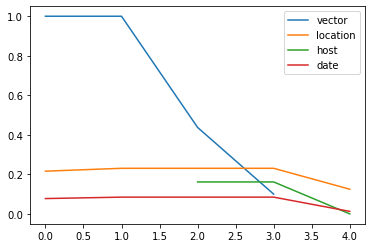

In [49]:
precision_df = pd.DataFrame.from_dict(precision_df)
precision_df.T.plot()

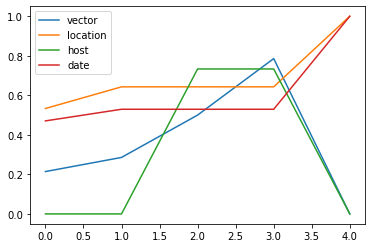

In [50]:
recall_df = pd.DataFrame.from_dict(recall_df)
recall_df.T.plot()

<AxesSubplot:>

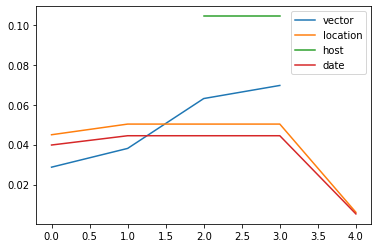

In [15]:
f1_df = pd.DataFrame.from_dict(f1_df)
f1_df.T.plot()